# Feature Ablation Study

## Load and Processs Data

In [1]:
import os
from dotenv import load_dotenv
from tabpfn_time_series.experimental.visualization.data_processing import load_wandb_runs

load_dotenv()

raw_df = load_wandb_runs(
    entity=os.getenv("WANDB_ENTITY"),
    project=os.getenv("WANDB_PROJECT_FEATURE_ABLATION"),
    tags=["main", "new_features_ablation"],
)

Fetching runs from W&B...
Found 510 runs in 31.29 seconds
Extracting basic run info...


Extracting run info: 100%|██████████| 510/510 [00:32<00:00, 15.55it/s]


Done extracting run info for 510 runs in 32.80 seconds


Processing runs: 100%|██████████| 510/510 [00:00<00:00, 317137.89it/s]


## Utils

In [2]:
df = raw_df.copy()

In [3]:
from tabpfn_time_series.experimental.visualization.data_processing import (
    rename_config_names
)

config_rename_dict = {
    "second-minute-paper-auto-seasonal-linear-pad-2-ex0": "Index + AutoSeasonal + Calendar",
    "index": "Index",
    "calendar": "Calendar",
    "auto-seasonal": "Auto-Seasonal",
    "auto-seasonal-linear-pad-2-ex0": "Index + Auto-Seasonal",
    "second-minute-paper": "Index + Calendar",
}

df = df[df['config_name'].isin(config_rename_dict.keys())]
df = rename_config_names(df, config_rename_dict)



## Import External Results

In [4]:
import pandas as pd
from tabpfn_time_series.experimental.visualization.data_processing import (
    load_external_results,
    get_common_subset
)

# Load external results
interested_models = ["Seasonal_Naive"]

external_df = load_external_results(
    interested_models=interested_models
)
# Combine with main DataFrame
df = pd.concat([df, external_df])
df = get_common_subset(df)

Number of datasets with all configurations completed: 81

Configurations per dataset:
config_name
Auto-Seasonal                      81
Calendar                           81
Index                              81
Index + Auto-Seasonal              81
Index + AutoSeasonal + Calendar    81
Index + Calendar                   81
Seasonal_Naive                     81
dtype: int64


## Metrics

In [5]:
from tabpfn_time_series.experimental.visualization.metrics import (
    normalize_metric_by_baseline,
    gmean_and_ci
)

# Normalize metrics
normalized_mase_df = normalize_metric_by_baseline(df, metric='MASE_0.5', baseline_model='Seasonal_Naive')
normalized_wql_df = normalize_metric_by_baseline(df, metric='wSQL_mean', baseline_model='Seasonal_Naive')

# Calculate geometric means and confidence intervals
norm_wql_mean_and_ci = normalized_wql_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['wSQL_mean']))
norm_mase_mean_and_ci = normalized_mase_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['MASE_0.5']))


In [6]:
norm_wql_mean_and_ci


,mean,ci_lower,ci_upper
config_name,,,
Auto-Seasonal,0.643872,0.544464,0.761430
Calendar,0.466264,0.411337,0.528526
Index,0.663115,0.577464,0.761469
Index + Auto-Seasonal,0.456354,0.401683,0.518467
Index + AutoSeasonal + Calendar,0.442900,0.390896,0.501822
Index + Calendar,0.451707,0.400615,0.509316
Seasonal_Naive,1.000000,1.000000,1.000000


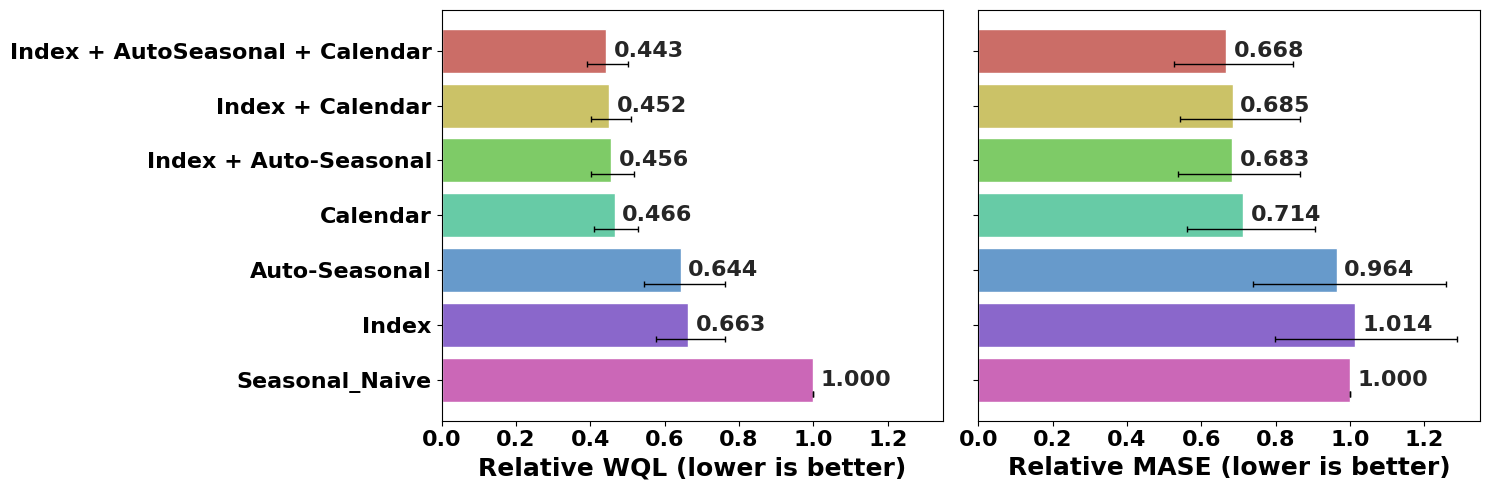

In [7]:
import matplotlib.pyplot as plt
from tabpfn_time_series.experimental.visualization.plotting import (
    plot_metric_comparison,
    save_plot_to_pdf,
)

feature_groups = norm_wql_mean_and_ci.sort_values('mean').index.tolist()

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot WQL comparison
plot_metric_comparison(
    norm_wql_mean_and_ci,
    xaxis_label="Relative WQL (lower is better)",
    feature_groups=feature_groups,
    ax=axes[0],
    xlim=(0, 1.35)
)

# Plot MASE comparison
plot_metric_comparison(
    norm_mase_mean_and_ci,
    xaxis_label="Relative MASE (lower is better)",
    feature_groups=feature_groups,
    ax=axes[1],
    xlim=(0, 1.35)
)

plt.tight_layout()
save_plot_to_pdf(fig, "context_length_ablation.pdf")
plt.show()
